In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import gc
import shutil
import calmap
from operator import itemgetter
# 需要改为你的root
root_path = '/high_perf_store3/data-lm/xiezixun/futures_predict'
data_path = os.path.join(root_path, 'data/赛题数据发布/赛道一/基本面数据/基本面数据_供应.csv')

# 设置完整显示所有行列
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
    
df = pd.read_csv(data_path, low_memory=False)
df.shape

(2409, 13)

In [2]:
df.columns

Index(['指标名称', 'OPEC：原油：产量：石油输出国组织+（月）', 'OPEC：原油：产量：沙特阿拉伯（月）',
       'OPEC：原油：产量：科威特（月）', 'OPEC：原油：产量：尼日利亚（月）', 'OPEC：原油：产量：委内瑞拉（月）',
       'OPEC：原油：产量：伊拉克（月）', 'OPEC：原油：产量：伊朗（月）', 'OPEC：战略储备石油：储备量：美国（月）',
       'OPEC：原油：产量：阿联酋（月）', '原油：日均产量预估值：美国（周）', 'EIA：原油：旋转钻机：在运行数量：美国（月）',
       '原油：产量：中国（月）'],
      dtype='object')

In [3]:
df.head()

,指标名称,OPEC：原油：产量：石油输出国组织+（月）,OPEC：原油：产量：沙特阿拉伯（月）,OPEC：原油：产量：科威特（月）,OPEC：原油：产量：尼日利亚（月）,OPEC：原油：产量：委内瑞拉（月）,OPEC：原油：产量：伊拉克（月）,OPEC：原油：产量：伊朗（月）,OPEC：战略储备石油：储备量：美国（月）,OPEC：原油：产量：阿联酋（月）,原油：日均产量预估值：美国（周）,EIA：原油：旋转钻机：在运行数量：美国（月）,原油：产量：中国（月）
0,2019/01/04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11700.0,NaN,NaN
1,2019/01/05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019/01/06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019/01/07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019/01/08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## NAN Search

In [4]:
nans_df = df.isna()
nans_groups={}
for col in df.columns:
    cur_group = nans_df[col].sum()
    try:
        nans_groups[cur_group].append(col)
    except:
        nans_groups[cur_group]=[col]
del nans_df; x=gc.collect()
nans_groups = sorted(nans_groups.items(), key=itemgetter(0), reverse=True)
for k,v in nans_groups:
    print(f'{v}: NAN count = {k}, share = {round(k / len(df) * 100, 2)}%')

['OPEC：原油：产量：沙特阿拉伯（月）']: NAN count = 2332, share = 96.8%
['OPEC：原油：产量：伊拉克（月）', 'EIA：原油：旋转钻机：在运行数量：美国（月）', '原油：产量：中国（月）']: NAN count = 2331, share = 96.76%
['OPEC：原油：产量：石油输出国组织+（月）', 'OPEC：原油：产量：科威特（月）', 'OPEC：原油：产量：尼日利亚（月）', 'OPEC：原油：产量：委内瑞拉（月）', 'OPEC：原油：产量：伊朗（月）', 'OPEC：战略储备石油：储备量：美国（月）', 'OPEC：原油：产量：阿联酋（月）']: NAN count = 2330, share = 96.72%
['原油：日均产量预估值：美国（周）']: NAN count = 2064, share = 85.68%
['指标名称']: NAN count = 0, share = 0.0%


# 离散值 & 连续值EDA

In [5]:
def summarize_df(df, nunique_threshold=100):
    """
    nunique_threshold : 一个数值型特征如果其唯一值数量低于此阈值，将被当作离散变量处理。
    """
    # 1. 连续变量分析
    # -------------------
    # 选择数值类型且唯一值数量 > nunique_threshold 的列
    continuous_cols = [
        col for col in df.columns 
        if pd.api.types.is_numeric_dtype(df[col]) and df[col].nunique() > nunique_threshold
    ]
    
    if continuous_cols:
        print("\n--- 1. 连续变量统计摘要 ---\n")
        
        # 使用describe高效计算基础统计量
        summary_conti = df[continuous_cols].describe().T
        
        # 添加更多有用的统计信息
        summary_conti['var'] = df[continuous_cols].var()
        summary_conti['skew'] = df[continuous_cols].skew()
        summary_conti['kurt'] = df[continuous_cols].kurt()
        summary_conti['nan_count'] = df[continuous_cols].isnull().sum()
        summary_conti['nan_share'] = summary_conti['nan_count'] / len(df)
        summary_conti['zeros_share'] = (df[continuous_cols] == 0).sum() / len(df)
        
        # 重新排列列的顺序，使其更合理
        summary_conti = summary_conti[['count', 'nan_count', 'nan_share', 'mean', 'std', 'var', 
                                       'skew', 'kurt', 'min', '25%', '50%', '75%', 'max', 'zeros_share']]
        
        # 使用style进行格式化输出
        display(summary_conti.style.format({
            'nan_share': '{:.2%}',
            'zeros_share': '{:.2%}',
            'mean': '{:.2f}',
            'std': '{:.2f}',
            'var': '{:.2f}',
            'skew': '{:.2f}',
            'kurt': '{:.2f}',
            'min': '{:.2f}',
            '25%': '{:.2f}',
            '50%': '{:.2f}',
            '75%': '{:.2f}',
            'max': '{:.2f}'
        }).background_gradient(cmap='viridis', subset=['nan_share', 'zeros_share'])
          .bar(subset=['mean', 'std'], color='#5fba7d'))

    else:
        print("\n--- 1. 无连续变量 ---\n")

    # 2. 离散变量分析-
    # -------------------
    # 选择非数值类型，或唯一值数量 <= nunique_threshold 的数值类型列
    discrete_cols = [
        col for col in df.columns 
        if not pd.api.types.is_numeric_dtype(df[col]) or df[col].nunique() <= nunique_threshold
    ]

    if discrete_cols:
        print("\n--- 2. 离散/分类变量统计摘要 ---\n")
        
        summary_discrete = []
        for col in discrete_cols:
            stats = {
                '特征名 (Feature)': col,
                '数据类型 (dtype)': df[col].dtype,
                '缺失值数量 (NaNs)': df[col].isnull().sum(),
                '缺失值占比 (NaNs Share)': f"{df[col].isnull().sum() / len(df):.2%}",
                '唯一值数量 (Unique)': df[col].nunique(),
                '众数 (Mode)': df[col].mode().iloc[0] if not df[col].mode().empty else 'N/A',
            }
            summary_discrete.append(stats)
            
        summary_df_discrete = pd.DataFrame(summary_discrete).set_index('特征名 (Feature)')
        display(summary_df_discrete)

        # 打印每个离散变量的详细值分布
        print("\n--- 3. 离散/分类变量值分布详情 ---\n")
        for col in discrete_cols:
            print(f"特征: '{col}'")
            # 计算值分布并转换为DataFrame
            value_dist = df[col].value_counts(dropna=False).to_frame(name='频数 (count)')
            value_dist['占比 (share)'] = (value_dist['频数 (count)'] / len(df))
            
            # 使用Styler格式化
            display(value_dist.style.format({'占比 (share)': '{:.2%}'})
                              .bar(subset=['占比 (share)'], color='lightblue', align='zero'))
            print("-" * 30)
    else:
        print("\n--- 2. 无离散/分类变量 ---\n")

summarize_df(df)


--- 1. 无连续变量 ---


--- 2. 离散/分类变量统计摘要 ---



,数据类型 (dtype),缺失值数量 (NaNs),缺失值占比 (NaNs Share),唯一值数量 (Unique),众数 (Mode)
特征名 (Feature),,,,,
指标名称,object,0,0.00%,2409,2019/01/04
OPEC：原油：产量：石油输出国组织+（月）,float64,2330,96.72%,79,22243.0
OPEC：原油：产量：沙特阿拉伯（月）,float64,2332,96.80%,74,8918.0
OPEC：原油：产量：科威特（月）,float64,2330,96.72%,50,2413.0
OPEC：原油：产量：尼日利亚（月）,float64,2330,96.72%,75,1258.0
OPEC：原油：产量：委内瑞拉（月）,float64,2330,96.72%,77,810.0
OPEC：原油：产量：伊拉克（月）,float64,2331,96.76%,69,4500.0
OPEC：原油：产量：伊朗（月）,float64,2330,96.72%,76,2565.0
OPEC：战略储备石油：储备量：美国（月）,float64,2330,96.72%,61,635.0



--- 3. 离散/分类变量值分布详情 ---

特征: '指标名称'


,频数 (count),占比 (share)
指标名称,,
2025/08/08,1,0.04%
2019/01/04,1,0.04%
2019/01/05,1,0.04%
2019/01/06,1,0.04%
2019/01/07,1,0.04%
2019/01/08,1,0.04%
2019/01/09,1,0.04%
2019/01/10,1,0.04%
2019/01/11,1,0.04%


------------------------------
特征: 'OPEC：原油：产量：石油输出国组织+（月）'


,频数 (count),占比 (share)
OPEC：原油：产量：石油输出国组织+（月）,,
nan,2330,96.72%
30793.000000,1,0.04%
30556.000000,1,0.04%
30034.000000,1,0.04%
30123.000000,1,0.04%
29945.000000,1,0.04%
29865.000000,1,0.04%
29605.000000,1,0.04%
29809.000000,1,0.04%


------------------------------
特征: 'OPEC：原油：产量：沙特阿拉伯（月）'


,频数 (count),占比 (share)
OPEC：原油：产量：沙特阿拉伯（月）,,
nan,2332,96.80%
8918.000000,2,0.08%
8972.000000,2,0.08%
8975.000000,2,0.08%
9787.000000,1,0.04%
9670.000000,1,0.04%
9782.000000,1,0.04%
9580.000000,1,0.04%
9807.000000,1,0.04%


------------------------------
特征: 'OPEC：原油：产量：科威特（月）'


,频数 (count),占比 (share)
OPEC：原油：产量：科威特（月）,,
nan,2330,96.72%
2413.000000,11,0.46%
2548.000000,8,0.33%
2676.000000,6,0.25%
2445.000000,2,0.08%
2290.000000,2,0.08%
2811.000000,2,0.08%
2295.000000,2,0.08%
2327.000000,2,0.08%


------------------------------
特征: 'OPEC：原油：产量：尼日利亚（月）'


,频数 (count),占比 (share)
OPEC：原油：产量：尼日利亚（月）,,
nan,2330,96.72%
1258.000000,2,0.08%
1361.000000,2,0.08%
1347.000000,2,0.08%
1486.000000,2,0.08%
1649.000000,1,0.04%
1802.000000,1,0.04%
1827.000000,1,0.04%
1713.000000,1,0.04%


------------------------------
特征: 'OPEC：原油：产量：委内瑞拉（月）'


,频数 (count),占比 (share)
OPEC：原油：产量：委内瑞拉（月）,,
nan,2330,96.72%
960.000000,2,0.08%
810.000000,2,0.08%
1488.000000,1,0.04%
1037.000000,1,0.04%
1432.000000,1,0.04%
1047.000000,1,0.04%
906.000000,1,0.04%
933.000000,1,0.04%


------------------------------
特征: 'OPEC：原油：产量：伊拉克（月）'


,频数 (count),占比 (share)
OPEC：原油：产量：伊拉克（月）,,
nan,2331,96.76%
4500.000000,4,0.17%
4595.000000,2,0.08%
4430.000000,2,0.08%
4470.000000,2,0.08%
4620.000000,2,0.08%
4651.000000,2,0.08%
4093.000000,2,0.08%
4575.000000,1,0.04%


------------------------------
特征: 'OPEC：原油：产量：伊朗（月）'


,频数 (count),占比 (share)
OPEC：原油：产量：伊朗（月）,,
nan,2330,96.72%
3161.000000,2,0.08%
3323.000000,2,0.08%
2565.000000,2,0.08%
2731.000000,1,0.04%
2367.000000,1,0.04%
2260.000000,1,0.04%
2218.000000,1,0.04%
2193.000000,1,0.04%


------------------------------
特征: 'OPEC：战略储备石油：储备量：美国（月）'


,频数 (count),占比 (share)
OPEC：战略储备石油：储备量：美国（月）,,
nan,2330,96.72%
644.800000,5,0.21%
635.000000,5,0.21%
649.100000,3,0.12%
638.100000,3,0.12%
637.800000,3,0.12%
621.300000,3,0.12%
371.600000,2,0.08%
351.300000,2,0.08%


------------------------------
特征: 'OPEC：原油：产量：阿联酋（月）'


,频数 (count),占比 (share)
OPEC：原油：产量：阿联酋（月）,,
nan,2330,96.72%
3070.000000,3,0.12%
3050.000000,2,0.08%
3045.000000,2,0.08%
3065.000000,2,0.08%
2990.000000,2,0.08%
2924.000000,2,0.08%
2914.000000,2,0.08%
2891.000000,2,0.08%


------------------------------
特征: '原油：日均产量预估值：美国（周）'


,频数 (count),占比 (share)
原油：日均产量预估值：美国（周）,,
nan,2064,85.68%
12200.000000,26,1.08%
12100.000000,24,1.00%
12300.000000,21,0.87%
11000.000000,21,0.87%
13100.000000,17,0.71%
13200.000000,17,0.71%
13300.000000,16,0.66%
11900.000000,16,0.66%


------------------------------
特征: 'EIA：原油：旋转钻机：在运行数量：美国（月）'


,频数 (count),占比 (share)
EIA：原油：旋转钻机：在运行数量：美国（月）,,
nan,2331,96.76%
486.000000,3,0.12%
501.000000,2,0.08%
181.000000,2,0.08%
475.000000,2,0.08%
678.000000,2,0.08%
483.000000,2,0.08%
478.000000,2,0.08%
802.000000,1,0.04%


------------------------------
特征: '原油：产量：中国（月）'


,频数 (count),占比 (share)
原油：产量：中国（月）,,
nan,2331,96.76%
1673.700000,2,0.08%
1609.600000,2,0.08%
1702.800000,2,0.08%
1687.200000,2,0.08%
1623.000000,1,0.04%
1610.000000,1,0.04%
1654.200000,1,0.04%
1571.100000,1,0.04%


------------------------------


# 日期EDA

提示：未指定列名，已自动选择第0列 '指标名称' 进行分析。
EDA for Date Column: '指标名称'
------------------------------
时间范围: 2019-01-04 to 2025-08-08
总记录数: 2409


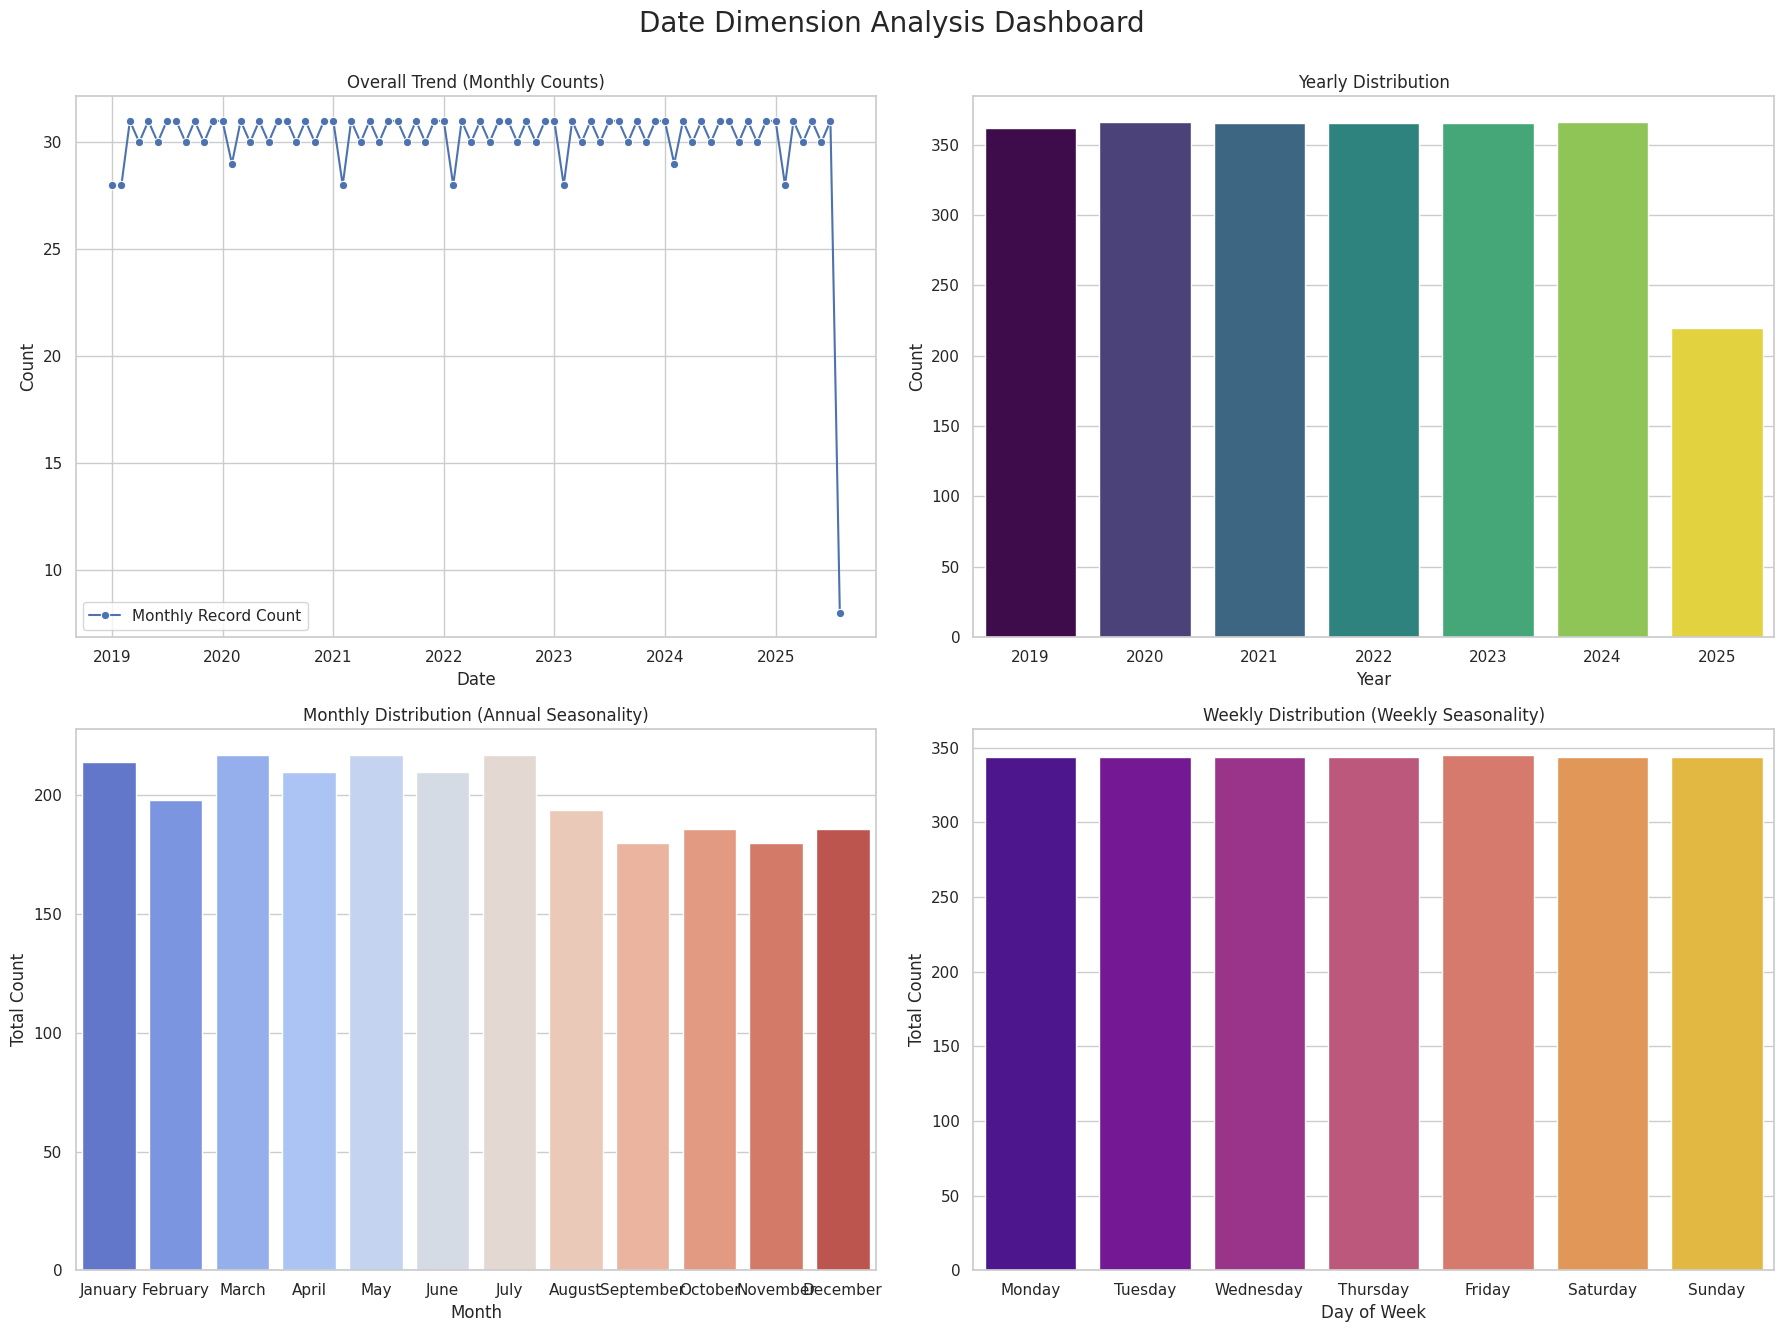


------------------------------
Annual Activity Calendar Heatmap


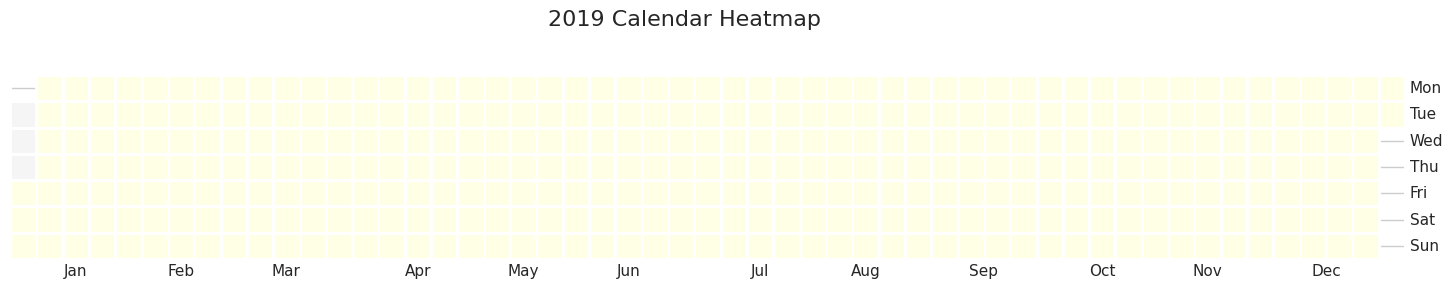

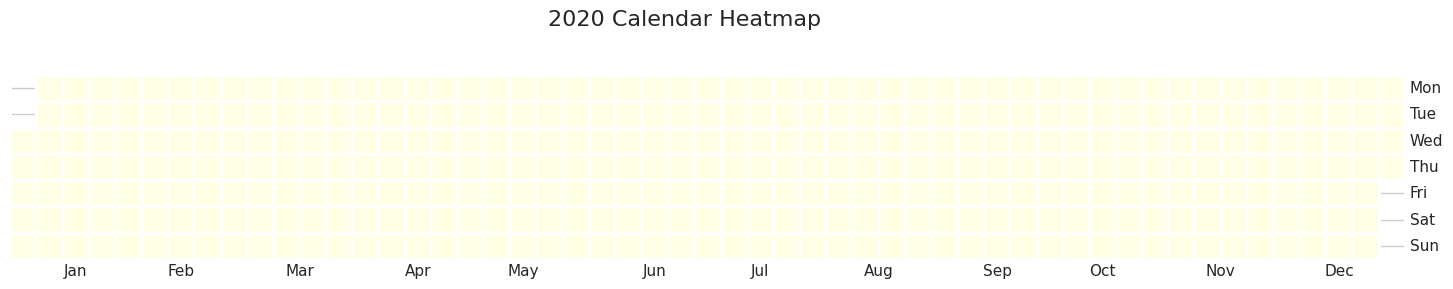

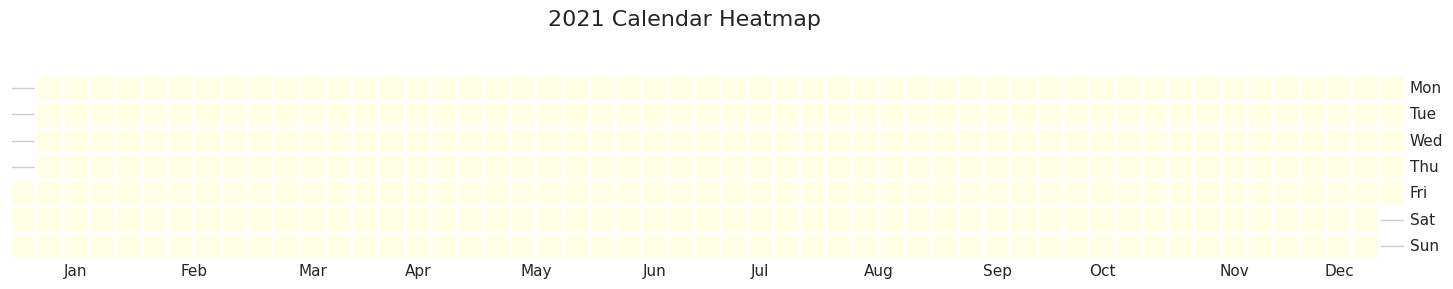

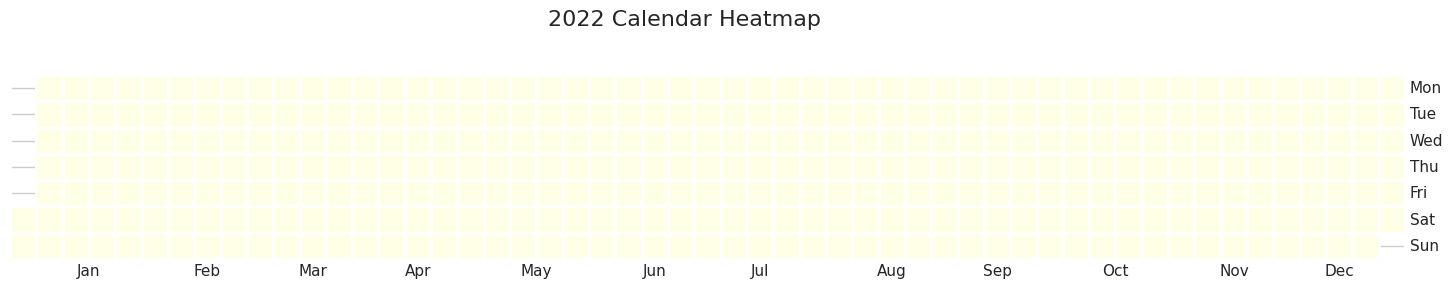

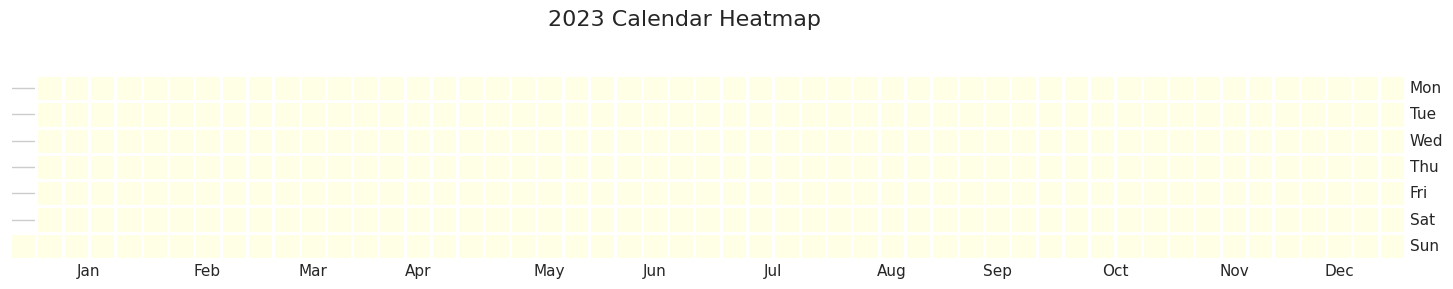

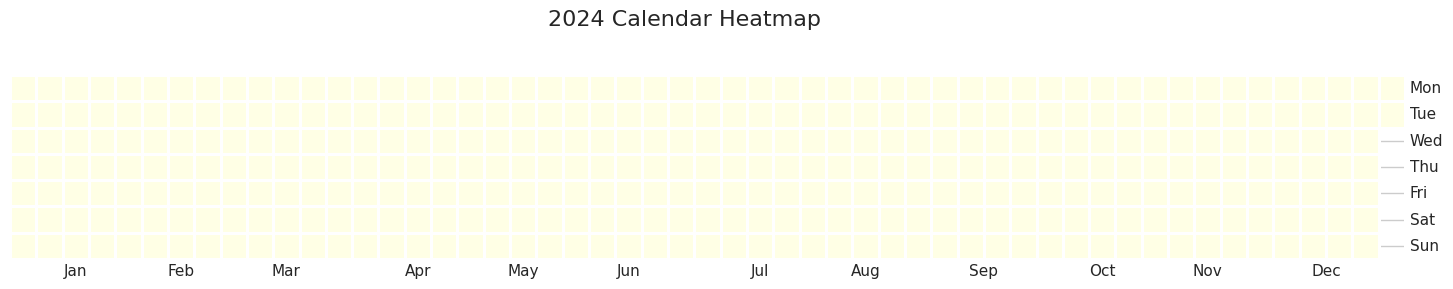

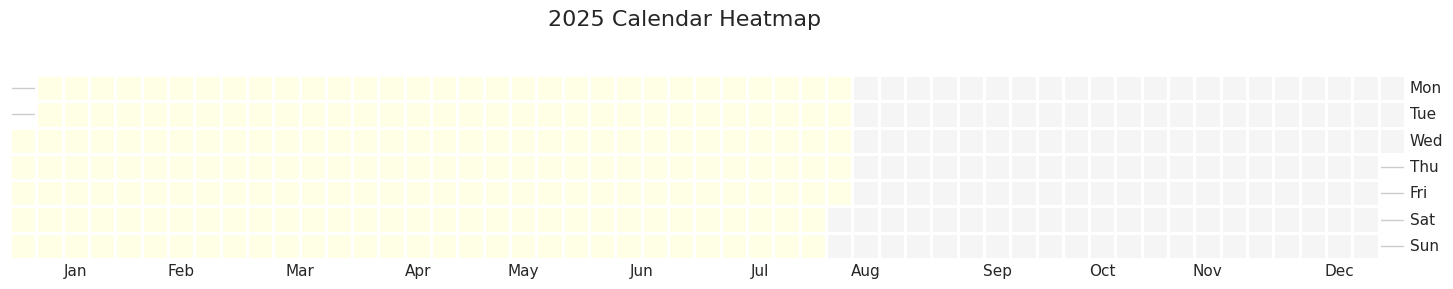

In [6]:
def eda_date_column(df, column_name=None):
    """
    column_name :
        要分析的日期列的名称。
        如果为None，函数会按以下顺序自动查找：
        1. 寻找名为 '日期' 的列。
        2. 使用第0列作为日期列。
    """
    
    # --- 1. 自动定位和预处理日期列 ---
    df_copy = df.copy()
    
    if column_name:
        if column_name not in df_copy.columns:
            print(f"错误：列 '{column_name}' 不存在于DataFrame中。")
            return
    else:
        if '日期' in df_copy.columns:
            column_name = '日期'
        else:
            column_name = df_copy.columns[0]
            print(f"提示：未指定列名，已自动选择第0列 '{column_name}' 进行分析。")

    try:
        # 转换为datetime对象，errors='coerce'会把无法转换的值设为NaT
        df_copy[column_name] = pd.to_datetime(df_copy[column_name], errors='coerce')
        # 移除转换后为空的行
        original_rows = len(df_copy)
        df_copy.dropna(subset=[column_name], inplace=True)
        if len(df_copy) < original_rows:
            print(f"提示：已移除 {original_rows - len(df_copy)} 个无法解析的日期行。")
    except Exception as e:
        print(f"错误：转换列 '{column_name}' 为日期时失败: {e}")
        return
        
    print(f"EDA for Date Column: '{column_name}'")
    print("-" * 30)
    min_date = df_copy[column_name].min().strftime('%Y-%m-%d')
    max_date = df_copy[column_name].max().strftime('%Y-%m-%d')
    print(f"时间范围: {min_date} to {max_date}")
    print(f"总记录数: {len(df_copy)}")
    
    # --- 2. 提取日期特征 ---
    s = df_copy[column_name]
    features = {
        '年份': s.dt.year,
        '月份': s.dt.month,
        '星期': s.dt.day_name(),
        '季度': s.dt.quarter,
        '周数': s.dt.isocalendar().week,
    }
    features_df = pd.DataFrame(features)
    
    # --- 3. 创建多维度可视化仪表盘 ---
    # 移除了 font='SimHei'
    sns.set_theme(style="whitegrid") 
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle(f"Date Dimension Analysis Dashboard", fontsize=20, y=0.95)
    
    # 图1: 按月统计的总体趋势
    monthly_counts = s.dt.to_period('M').value_counts().sort_index()
    monthly_counts.index = monthly_counts.index.to_timestamp()
    sns.lineplot(data=monthly_counts, ax=axes[0, 0], marker='o', label='Monthly Record Count')
    axes[0, 0].set_title('Overall Trend (Monthly Counts)')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Count')
    
    # 图2: 按年份分布
    sns.countplot(data=features_df, x='年份', hue='年份', legend=False, ax=axes[0, 1], palette='viridis')
    axes[0, 1].set_title('Yearly Distribution')
    axes[0, 1].set_xlabel('Year')
    axes[0, 1].set_ylabel('Count')
    
    # 图3: 按月份分布 (年度周期性)
    month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']
    
    month_counts = features_df['月份'].value_counts().sort_index()
    month_counts.index = month_counts.index.map(lambda x: pd.to_datetime(f'2000-{x}-01').strftime('%B'))
    month_counts = month_counts.reindex(month_order).fillna(0)

    sns.barplot(x=month_counts.index, hue=month_counts.index, legend=False, y=month_counts.values, ax=axes[1, 0], palette='coolwarm')
    axes[1, 0].set_title('Monthly Distribution (Annual Seasonality)')
    axes[1, 0].set_xlabel('Month')
    axes[1, 0].set_ylabel('Total Count')
    
    # 图4: 按星期分布 (周度周期性)
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    day_counts = features_df['星期'].value_counts().reindex(day_order)
    
    sns.barplot(x=day_counts.index, hue=day_counts.index, legend=False, y=day_counts.values, ax=axes[1, 1], palette='plasma')
    axes[1, 1].set_title('Weekly Distribution (Weekly Seasonality)')
    axes[1, 1].set_xlabel('Day of Week')
    axes[1, 1].set_ylabel('Total Count')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # --- 4. [优雅的可视化] 绘制日历热力图, 黄色说明有活动,灰色说明没这个日期 ---
    try:
        print("\n" + "-" * 30)
        print("Annual Activity Calendar Heatmap")
        daily_counts = s.dt.date.value_counts()
        daily_counts.index = pd.to_datetime(daily_counts.index)
        
        # 为每个年份绘制一张图
        for year in sorted(daily_counts.index.year.unique()):
            plt.figure(figsize=(18, 3))
            calmap.yearplot(daily_counts, year=year, cmap='YlGn')
            plt.suptitle(f'{year} Calendar Heatmap', fontsize=16, y=1.02)
            plt.show()
    except Exception as e:
        print(f"提示：无法绘制日历热力图，可能因为数据量或日期范围问题。错误: {e}")

eda_date_column(df)

# 相关性分析

In [7]:
def encode_FE(df, cols):
    for col in cols:
        vc = df[col].value_counts(dropna=True, normalize=True).to_dict()
        df[col] = df[col].map(vc)
        df[col] = df[col].astype('float32')
    return df

def analyze_correlation(df):
    """
    自动预处理DataFrame并分析列之间的相关性。

    过程:
    1. 复制原始DataFrame以避免修改。
    2. 自动检测并转换日期/时间类型的列 (包括字符串格式) 为Unix时间戳。
    3. 对剩余的字符串(分类)列进行频率编码。
    4. 计算处理后所有数值列的相关性矩阵。

    参数:
        df (pd.DataFrame): 需要分析的输入DataFrame。

    返回:
        tuple: 一个包含两个元素的元组:
            - (pd.DataFrame): 经过预处理的全数值DataFrame。
            - (pd.DataFrame): 计算出的相关性矩阵。
    """
    print("--- 启动分析流程 ---")
    df_processed = df.copy()

    # 步骤 1: 优先处理日期/时间类型的列
    # 这样可以避免日期字符串被错误地当作普通分类变量处理
    date_cols_found = []
    for col in df_processed.columns:
        # 只尝试转换非数值类型的列
        if df_processed[col].dtype == 'object' or pd.api.types.is_datetime64_any_dtype(df_processed[col].dtype):
            try:
                # 尝试将列转换为datetime格式，无法转换的值会变为NaT
                temp_dt = pd.to_datetime(df_processed[col], errors='coerce')
                
                # 如果转换后至少有一个有效日期，则认为该列是日期列
                if not temp_dt.isnull().all():
                    print(f"检测到日期/时间列: '{col}' -> 转换为Unix时间戳")
                    # 转换为以秒为单位的Unix时间戳
                    df_processed[col] = temp_dt.astype('int64') // 10**9
                    date_cols_found.append(col)
            except (ValueError, TypeError):
                # 如果转换失败，说明不是日期列，跳过
                continue
    
    # 步骤 2: 处理剩余的字符串 (分类) 列
    # 选择所有数据类型仍为 'object' 的列
    str_cols_to_encode = df_processed.select_dtypes(include=['object']).columns.tolist()

    if str_cols_to_encode:
        print(f"检测到字符/分类列: {str_cols_to_encode} -> 进行频率编码")
        df_processed = encode_FE(df_processed, str_cols_to_encode)
    else:
        print("未找到需要频率编码的字符/分类列。")

    # 步骤 3: 计算相关性矩阵
    # 确保所有列都是数值类型
    numeric_cols = df_processed.select_dtypes(include=np.number).columns.tolist()
    if len(numeric_cols) != len(df_processed.columns):
        print("\n警告: 并非所有列都能转换为数值类型。相关性将只在数值列上计算。")
    
    print("正在计算相关性矩阵...")
    correlation_matrix = df_processed[numeric_cols].corr()
    
    print("--- 分析流程结束 ---")
    return df_processed, correlation_matrix

df_processed_result, correlation_matrix_result = analyze_correlation(df)
print(correlation_matrix_result)

print("\n\n" + "="*50)
print("      各列的 Top 5 最高相关性分析")
print("="*50)

# 遍历相关性矩阵中的每一列
for column in correlation_matrix_result.columns:
    print(f"\n--- 与 '{column}' 相关性最高的 Top 5 列 ---")
    correlations = correlation_matrix_result[column].drop(column)
    
    # 2. 找到绝对值最高的5个相关性的索引 (列名)
    #    使用 .abs() 来确保强负相关也被认为是“高”相关性
    #    使用 .nlargest(5) 来高效获取前5个值
    top_5_indices = correlations.abs().nlargest(5).index
    
    # 3. 使用这些索引从原始的相关性级数中 (包含正负号) 获取并显示结果
    top_5_values = correlations.loc[top_5_indices]
    
    # 4. 检查是否有足够的相关列可供显示
    if top_5_values.empty:
        print("没有其他列可进行相关性比较。")
    else:
        print(top_5_values)


--- 启动分析流程 ---
检测到日期/时间列: '指标名称' -> 转换为Unix时间戳
未找到需要频率编码的字符/分类列。
正在计算相关性矩阵...
--- 分析流程结束 ---
                             指标名称  OPEC：原油：产量：石油输出国组织+（月）  \
指标名称                     1.000000               -0.210774   
OPEC：原油：产量：石油输出国组织+（月）  -0.210774                1.000000   
OPEC：原油：产量：沙特阿拉伯（月）     -0.167914                0.813566   
OPEC：原油：产量：科威特（月）       -0.240524                0.908957   
OPEC：原油：产量：尼日利亚（月）      -0.483737                0.222769   
OPEC：原油：产量：委内瑞拉（月）       0.221110                0.561254   
OPEC：原油：产量：伊拉克（月）       -0.530058                0.824723   
OPEC：原油：产量：伊朗（月）         0.858553                0.025704   
OPEC：战略储备石油：储备量：美国（月）   -0.896317               -0.031947   
OPEC：原油：产量：阿联酋（月）        0.033724                0.819996   
原油：日均产量预估值：美国（周）         0.602922                0.363950   
EIA：原油：旋转钻机：在运行数量：美国（月） -0.219491                0.908066   
原油：产量：中国（月）              0.854651               -0.158074   

                         OPEC：原油：产量：沙特阿拉伯（月）  OPEC：原